# **Mini Project II**

Jun Park, Bryan Rachmat

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import seaborn as sns

## Dataset Description

**What:** Predict whether a patient has heart disease  

**Source:** Heart Disease Dataset  

**Features:** 14  
- age: Age  
- sex: Sex  
- cp: Chest pain type  
- trestbps: Resting blood pressure  
- chol: Serum cholesterol  
- fbs: Fasting blood sugar  
- restecg: Resting ECG results  
- thalach: Maximum heart rate  
- exang: Exercise-induced angina  
- oldpeak: Oldpeak (ST depression)  
- slope: Slope of peak exercise ST segment  
- ca: Number of major vessels  
- thai: Thalassemia  

**Target:** Binary classification  
- 0 = No disease  
- 1 = Disease  

**Dataset Size:** 303 samples  

**Class Balance:** Roughly balanced  
- ~54% with disease  
- ~46% healthy  


In [2]:
# Load dataset
df = pd.read_csv("../data/heart.csv")

# Print dataset description
print("Dataset Description:")
df.describe().T


Dataset Description:


,count,mean,std,min,25%,50%,75%,max
age,1025.0,54.434146,9.072290,29.0,48.0,56.0,61.0,77.0
sex,1025.0,0.695610,0.460373,0.0,0.0,1.0,1.0,1.0
cp,1025.0,0.942439,1.029641,0.0,0.0,1.0,2.0,3.0
trestbps,1025.0,131.611707,17.516718,94.0,120.0,130.0,140.0,200.0
chol,1025.0,246.000000,51.592510,126.0,211.0,240.0,275.0,564.0
fbs,1025.0,0.149268,0.356527,0.0,0.0,0.0,0.0,1.0
restecg,1025.0,0.529756,0.527878,0.0,0.0,1.0,1.0,2.0
thalach,1025.0,149.114146,23.005724,71.0,132.0,152.0,166.0,202.0
exang,1025.0,0.336585,0.472772,0.0,0.0,0.0,1.0,1.0
oldpeak,1025.0,1.071512,1.175053,0.0,0.0,0.8,1.8,6.2


In [3]:
# Check for missing values per column
df.isnull().sum()
df = df.drop_duplicates()
df.duplicated().sum()


np.int64(0)

In [4]:
df["target"].value_counts(normalize=True)

target
1    0.543046
0    0.456954
Name: proportion, dtype: float64

**Renaming Features**

In [5]:
df = df.rename(columns={
    "age": "age",
    "sex": "sex",
    "cp": "chest_pain_type",
    "trestbps": "resting_blood_pressure",
    "chol": "cholesterol",
    "fbs": "fasting_blood_sugar",
    "restecg": "resting_ecg",
    "thalach": "max_heart_rate",
    "exang": "exercise_induced_angina",
    "oldpeak": "st_depression",
    "slope": "st_slope",
    "ca": "num_major_vessels",
    "thal": "thalassemia",
    "target": "heart_disease"
})


df.columns

Index(['age', 'sex', 'chest_pain_type', 'resting_blood_pressure',
       'cholesterol', 'fasting_blood_sugar', 'resting_ecg', 'max_heart_rate',
       'exercise_induced_angina', 'st_depression', 'st_slope',
       'num_major_vessels', 'thalassemia', 'heart_disease'],
      dtype='str')

In [6]:
categorical_cols = [
    "sex",
    "chest_pain_type",
    "fasting_blood_sugar",
    "resting_ecg",
    "exercise_induced_angina",
    "st_slope",
    "num_major_vessels",
    "thalassemia"
]

# Apply one-hot encoding
df_encoded = pd.get_dummies(
    df,
    columns=categorical_cols,
    drop_first=True
)

# Verify results
print(df_encoded.head())
print("\nEncoded shape:", df_encoded.shape)
print("\nEncoded columns:")
print(df_encoded.columns)


   age  resting_blood_pressure  cholesterol  max_heart_rate  st_depression  \
0   52                     125          212             168            1.0   
1   53                     140          203             155            3.1   
2   70                     145          174             125            2.6   
3   61                     148          203             161            0.0   
4   62                     138          294             106            1.9   

   heart_disease  sex_1  chest_pain_type_1  chest_pain_type_2  \
0              0   True              False              False   
1              0   True              False              False   
2              0   True              False              False   
3              0   True              False              False   
4              0  False              False              False   

   chest_pain_type_3  ...  exercise_induced_angina_1  st_slope_1  st_slope_2  \
0              False  ...                      False       F

### **Exploratory Data Analysis**





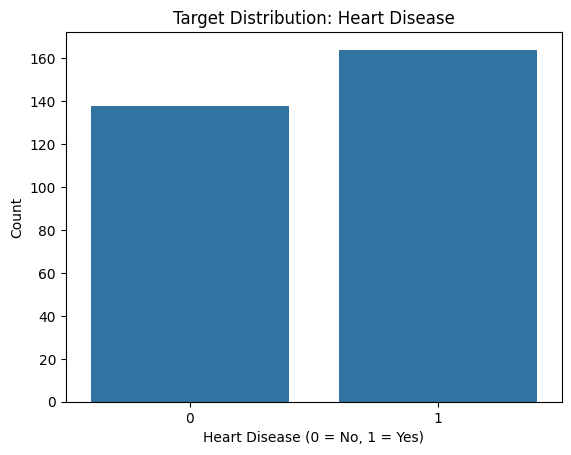

In [7]:
sns.countplot(x="heart_disease", data=df)
plt.title("Target Distribution: Heart Disease")
plt.xlabel("Heart Disease (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

### Target Distribution

*   54% disease
*   46% healthy

The balanced distribution reduces the risk of model bias towards one class likelywill not need resampling techniques.

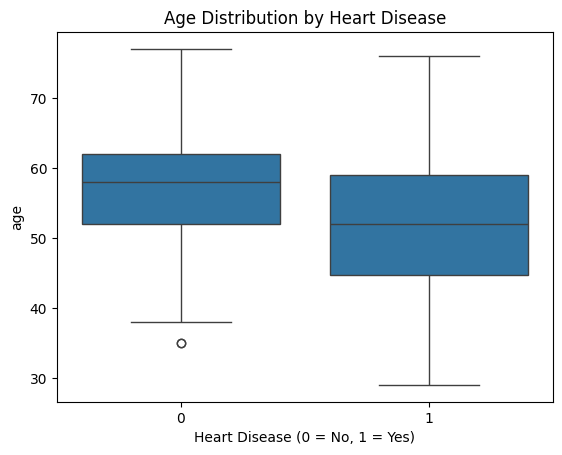

In [8]:
sns.boxplot(
    x="heart_disease",
    y="age",
    data=df
)
plt.title("Age Distribution by Heart Disease")
plt.xlabel("Heart Disease (0 = No, 1 = Yes)")
plt.show()


### Age / Heart Disease

**Weak / Moderate predictive feature**

Even though heart disease is often associated with older age, there is significant overlap between the two groups. Which means that age alone does not clearly separate healthy vs diseased patients.

Age may be a contributing risk factor but not a strong standalone predictor of heart disease.

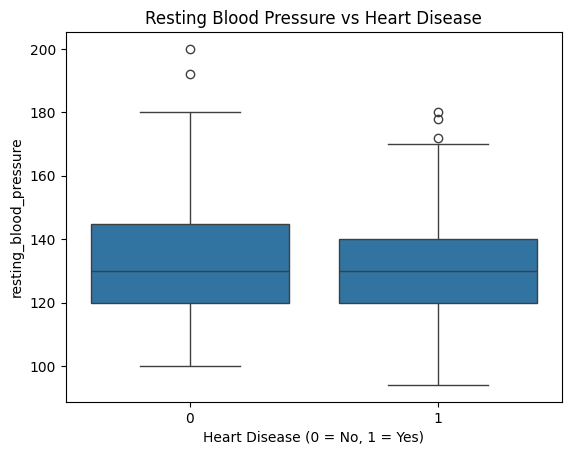

In [9]:
sns.boxplot(x="heart_disease", y="resting_blood_pressure", data=df)
plt.title("Resting Blood Pressure vs Heart Disease")
plt.xlabel("Heart Disease (0 = No, 1 = Yes)")
plt.show()


### Resting Blood Pressure / Heart Disease

**Weak / Moderate predictive feature**

Resting blood pressure shows similar median values and distribution ranges for both classes, with a lot of overlap observed. This suggests that resting blood pressure has limited predictive power when considered alone.

Resting Blood Pressure may be a contributing risk factor but not a strong predictor of heart disease.

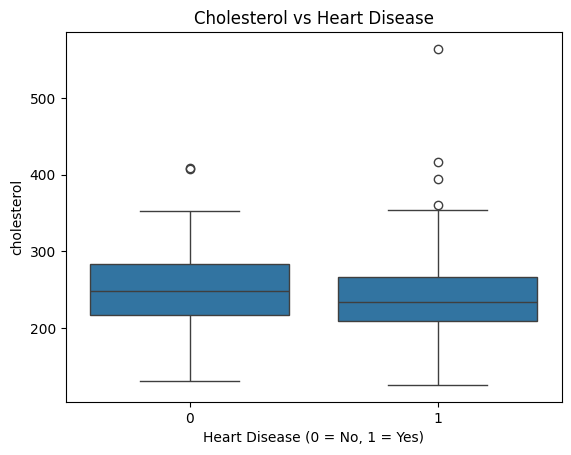

In [10]:
sns.boxplot(x="heart_disease", y="cholesterol", data=df)
plt.title("Cholesterol vs Heart Disease")
plt.xlabel("Heart Disease (0 = No, 1 = Yes)")
plt.show()


### Cholestrol / Heart Disease

**Weak / Moderate predictive feature**

Cholestrol shows similar median values and distribution ranges for both classes, with a lot of overlap observed. This suggests that cholestrol has limited predictive power when considered alone.

Cholestrol may be a contributing risk factor but not a strong predictor of heart disease.

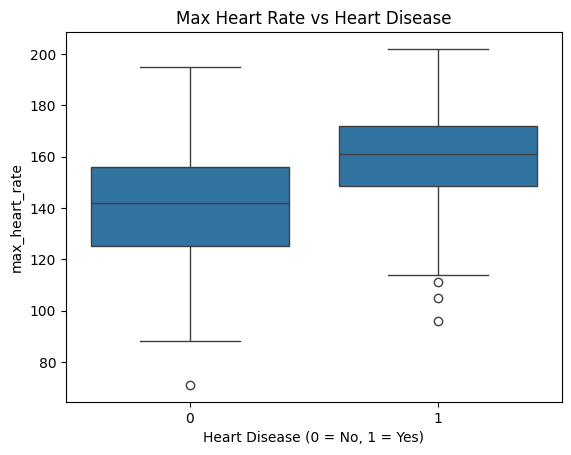

In [11]:
sns.boxplot(x="heart_disease", y="max_heart_rate", data=df)
plt.title("Max Heart Rate vs Heart Disease")
plt.xlabel("Heart Disease (0 = No, 1 = Yes)")
plt.show()


### Max Heart Rate / Heart Disease

**Moderate / Strong predictive feature**

Maximum heart rate shows a clear separation between patients with and without heart disease, with diseased patients generally achieving higher maximum heart rates.

The difference in medians and reduced overlap between distributions highlight this feature is a strong predictor.

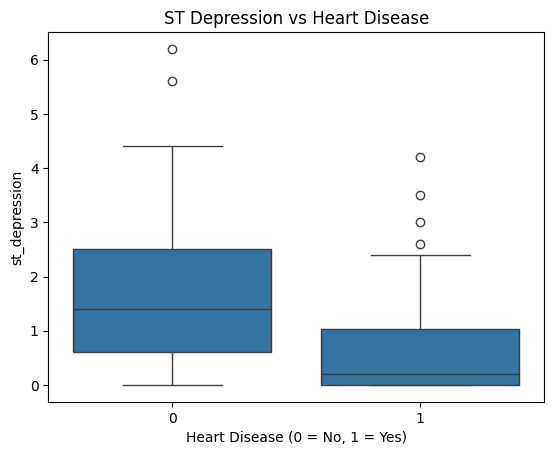

In [12]:
sns.boxplot(x="heart_disease", y="st_depression", data=df)
plt.title("ST Depression vs Heart Disease")
plt.xlabel("Heart Disease (0 = No, 1 = Yes)")
plt.show()


### Age / Heart Disease

**Moderate / Strong predictive feature**

ST depression also shows a big difference between the two groups, with patients diagnosed with heart disease showing higher values on average. The limited overlap and distinct medians indicate strong discriminative power.

ST depression would be a strong predictive feature

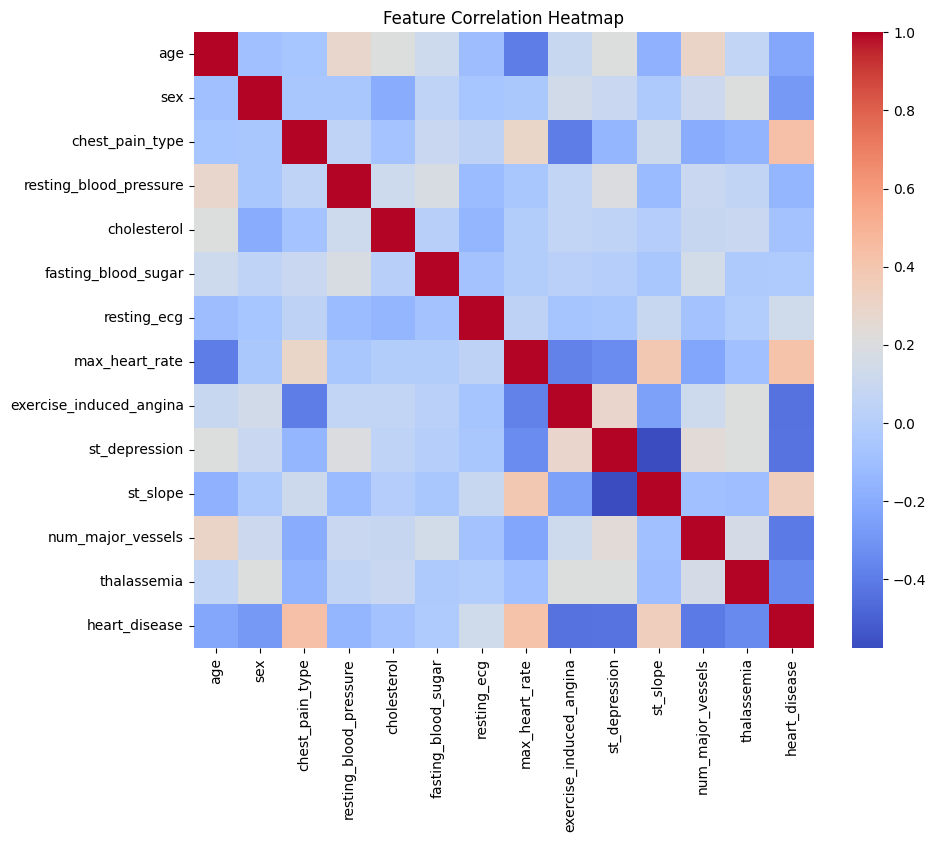

In [13]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    df.corr(),
    cmap="coolwarm",
    annot=False
)
plt.title("Feature Correlation Heatmap")
plt.show()


## Strong Correlations

*   ST slope / depression
*   Chest pain type
*   Max heart rate
*   Number of major vessels
*   Exercise induced angina


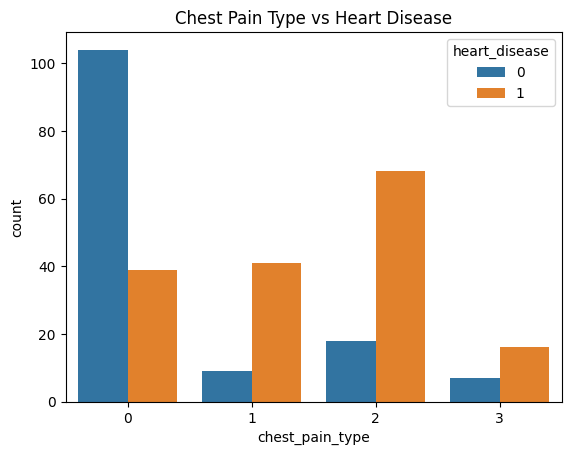

In [14]:
sns.countplot(
    x="chest_pain_type",
    hue="heart_disease",
    data=df
)
plt.title("Chest Pain Type vs Heart Disease")
plt.show()


The distribution of chest pain types shows a strong association with heart disease outcomes.

Type 1,2, and 3 shows a substantially higher proportion of patients diagnosed with heart disease, while type 0 is more common among non-diseased patients. This indicates that chest pain type is a highly informative categorical feature and a key predictor in the model.